In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

from tqdm import tqdm

# from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
# from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import re

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.preprocessing import StandardScaler
from bs4 import BeautifulSoup

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ratemeter/sample_submission.csv
/kaggle/input/ratemeter/train.csv
/kaggle/input/ratemeter/test.csv


In [3]:
train = pd.read_csv('/kaggle/input/ratemeter/train.csv')
train.head()

,user_id,book_id,review_id,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments,rating
0,1c845473e18c23f917126cb29bc8d243,6547260,5805e560deacf886537b2e76b2653515,I finished this in two days. THIS SERIES IS JU...,Sat Nov 16 00:26:42 -0800 2013,Mon Jan 26 11:14:39 -0800 2015,Mon Jan 26 11:14:39 -0800 2015,Sat Jan 24 00:00:00 -0800 2015,0,0,5
1,0867fa7e18da1a292d0256fad0ee4e31,17201095,84c2e89581004bedd01dea2833bed181,Review to follow \n Goodreads 4 \n Amazon 5 \n...,Wed Jan 02 11:22:44 -0800 2013,Sun Apr 28 20:23:22 -0700 2013,NaN,NaN,0,0,5
2,a57237ef712461148672852d8f47e300,16143347,956d4ea003698d83c1495cc251be5bc0,I will have a full review up eventually but fo...,Thu Jun 19 15:48:04 -0700 2014,Thu May 05 09:09:58 -0700 2016,Thu Jun 19 00:00:00 -0700 2014,Thu Jun 19 00:00:00 -0700 2014,0,0,5
3,80589c77f4fa826eaaf7c5d71ff3b81e,7863423,e5ed7e0401cbe5c44e7b7ee4e1af4f09,4 stars. Aww! I loved this one! I have read th...,Wed Sep 16 18:52:06 -0700 2015,Sun Sep 20 18:34:34 -0700 2015,Sun Sep 20 00:00:00 -0700 2015,Sat Sep 19 00:00:00 -0700 2015,1,0,4
4,916977f433fbf96ae9de9669f8aec040,17262303,51b4449f83ff8c9d13a3b6aa2df4fb27,this is official: Patrick Ness is my fav author,Sun Oct 13 11:47:17 -0700 2013,Mon Sep 15 17:51:03 -0700 2014,Tue Sep 16 17:51:03 -0700 2014,NaN,0,0,5


In [4]:
# train = train.iloc[:1000]
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       630000 non-null  object
 1   book_id       630000 non-null  int64 
 2   review_id     630000 non-null  object
 3   review_text   630000 non-null  object
 4   date_added    630000 non-null  object
 5   date_updated  630000 non-null  object
 6   read_at       565775 non-null  object
 7   started_at    437963 non-null  object
 8   n_votes       630000 non-null  int64 
 9   n_comments    630000 non-null  int64 
 10  rating        630000 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 52.9+ MB


In [5]:
train.head()

,user_id,book_id,review_id,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments,rating
0,1c845473e18c23f917126cb29bc8d243,6547260,5805e560deacf886537b2e76b2653515,I finished this in two days. THIS SERIES IS JU...,Sat Nov 16 00:26:42 -0800 2013,Mon Jan 26 11:14:39 -0800 2015,Mon Jan 26 11:14:39 -0800 2015,Sat Jan 24 00:00:00 -0800 2015,0,0,5
1,0867fa7e18da1a292d0256fad0ee4e31,17201095,84c2e89581004bedd01dea2833bed181,Review to follow \n Goodreads 4 \n Amazon 5 \n...,Wed Jan 02 11:22:44 -0800 2013,Sun Apr 28 20:23:22 -0700 2013,NaN,NaN,0,0,5
2,a57237ef712461148672852d8f47e300,16143347,956d4ea003698d83c1495cc251be5bc0,I will have a full review up eventually but fo...,Thu Jun 19 15:48:04 -0700 2014,Thu May 05 09:09:58 -0700 2016,Thu Jun 19 00:00:00 -0700 2014,Thu Jun 19 00:00:00 -0700 2014,0,0,5
3,80589c77f4fa826eaaf7c5d71ff3b81e,7863423,e5ed7e0401cbe5c44e7b7ee4e1af4f09,4 stars. Aww! I loved this one! I have read th...,Wed Sep 16 18:52:06 -0700 2015,Sun Sep 20 18:34:34 -0700 2015,Sun Sep 20 00:00:00 -0700 2015,Sat Sep 19 00:00:00 -0700 2015,1,0,4
4,916977f433fbf96ae9de9669f8aec040,17262303,51b4449f83ff8c9d13a3b6aa2df4fb27,this is official: Patrick Ness is my fav author,Sun Oct 13 11:47:17 -0700 2013,Mon Sep 15 17:51:03 -0700 2014,Tue Sep 16 17:51:03 -0700 2014,NaN,0,0,5


In [6]:
train['rating'].value_counts()

rating
4    219581
5    185505
3    132280
2     50839
0     21692
1     20103
Name: count, dtype: int64

<Axes: >

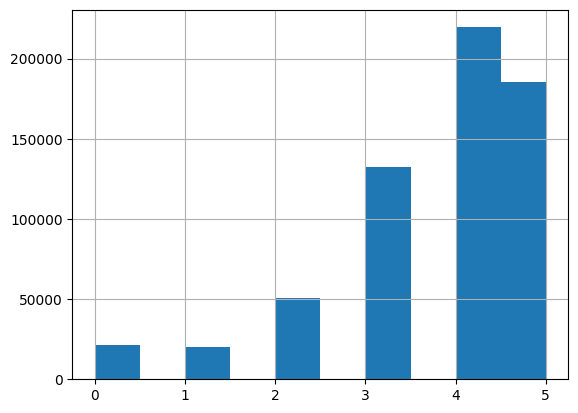

In [7]:
train["rating"].hist()

In [8]:
# Text Lowercasing
train['review_text'] = train['review_text'].str.lower()

In [9]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"ain\'t", "am not", phrase)
    phrase = re.sub(r"aren\'t", "are not", phrase)
    phrase = re.sub(r"can't've", "cannot have", phrase)
    phrase = re.sub(r"\'cause", "because", phrase)
    phrase = re.sub(r"could've", "could have", phrase)
    phrase = re.sub(r"couldn't", "could not", phrase)
    phrase = re.sub(r"couldn't've", "could not have", phrase)
    phrase = re.sub(r"didn't", "did not", phrase)
    phrase = re.sub(r"doesn't", "does not", phrase)
    phrase = re.sub(r"don't", "do not", phrase)
    phrase = re.sub(r"hadn't", "had not", phrase)
    phrase = re.sub(r"hadn't've", "had not have", phrase)
    phrase = re.sub(r"hasn't", "has not", phrase)
    phrase = re.sub(r"haven't", "have not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def expand(x):
    contractions = {
        "he'd": 'he would',
        "he'd've": 'he would have',
        "he'll": 'he will',
        "he'll've": 'he will have',
        "he's": 'he is',
        "how'd": 'how did',
        "how'd'y": 'how do you',
        "how'll": 'how will',
        "how's": 'how does',
        "i'd": 'i would',
        "i'd've": 'i would have',
        "i'll": 'i will',
        "i'll've": 'i will have',
        "i'm": 'i am',
        "i've": 'i have',
        "isn't": 'is not',
        "it'd": 'it would',
        "it'd've": 'it would have',
        "it'll": 'it will',
        "it'll've": 'it will have',
        "it's": 'it is',
        "let's": 'let us',
        "ma'am": 'madam',
        "mayn't": 'may not',
        "might've": 'might have',
        "mightn't": 'might not',
        "mightn't've": 'might not have',
        "must've": 'must have',
        "mustn't": 'must not',
        "mustn't've": 'must not have',
        "needn't": 'need not',
        "needn't've": 'need not have',
        "o'clock": 'of the clock',
        "oughtn't": 'ought not',
        "oughtn't've": 'ought not have',
        "shan't": 'shall not',
        "sha'n't": 'shall not',
        "shan't've": 'shall not have',
        "she'd": 'she would',
        "she'd've": 'she would have',
        "she'll": 'she will',
        "she'll've": 'she will have',
        "she's": 'she is',
        "should've": 'should have',
        "shouldn't": 'should not',
        "shouldn't've": 'should not have',
        "so've": 'so have',
        "so's": 'so is',
        "that'd": 'that would',
        "that'd've": 'that would have',
        "that's": 'that is',
        "there'd": 'there would',
        "there'd've": 'there would have',
        "there's": 'there is',
        "they'd": 'they would',
        "they'd've": 'they would have',
        "they'll": 'they will',
        "they'll've": 'they will have',
        "they're": 'they are',
        "they've": 'they have',
        "to've": 'to have',
        "wasn't": 'was not',
        ' u ': ' you ',
        ' ur ': ' your ',
        ' n ': ' and ',
    }
    
    for key in contractions:
        value = contractions[key]
        x = x.replace(key, value)
    return x

def removepunc(x):
        punctuation = \
            '!\xe2\x80\x9d$%&\xe2\x80\x99()*+-/:;<=>[]^_`{|}~\xe2\x80\xa2@#'
        return x.translate(str.maketrans('', '', punctuation))

def text_processing(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"\n", "", text)
    text = re.sub(r"&", "and", text)
    text = BeautifulSoup(text, 'lxml').get_text()
    text = decontracted(text)
    removepunc(text)
    return text

In [10]:
# Decontracting , removing html tags ang removing links
train['review_text'] = train['review_text'].apply(text_processing)

In [11]:
# Expand shortcuts
train['review_text'] = train['review_text'].apply(lambda x: expand(x))

In [12]:
# Remove Punctuation and Non-Alphabetic Characters
# train['review_text'] = train['review_text'].apply(lambda tokens: [word for word in tokens if word.isalpha()])

In [13]:
train.head()

,user_id,book_id,review_id,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments,rating
0,1c845473e18c23f917126cb29bc8d243,6547260,5805e560deacf886537b2e76b2653515,i finished this in two days. this series is ju...,Sat Nov 16 00:26:42 -0800 2013,Mon Jan 26 11:14:39 -0800 2015,Mon Jan 26 11:14:39 -0800 2015,Sat Jan 24 00:00:00 -0800 2015,0,0,5
1,0867fa7e18da1a292d0256fad0ee4e31,17201095,84c2e89581004bedd01dea2833bed181,review to follow goodreads 4 amazon 5 overa...,Wed Jan 02 11:22:44 -0800 2013,Sun Apr 28 20:23:22 -0700 2013,NaN,NaN,0,0,5
2,a57237ef712461148672852d8f47e300,16143347,956d4ea003698d83c1495cc251be5bc0,i will have a full review up eventually but fo...,Thu Jun 19 15:48:04 -0700 2014,Thu May 05 09:09:58 -0700 2016,Thu Jun 19 00:00:00 -0700 2014,Thu Jun 19 00:00:00 -0700 2014,0,0,5
3,80589c77f4fa826eaaf7c5d71ff3b81e,7863423,e5ed7e0401cbe5c44e7b7ee4e1af4f09,4 stars. aww! i loved this one! i have read th...,Wed Sep 16 18:52:06 -0700 2015,Sun Sep 20 18:34:34 -0700 2015,Sun Sep 20 00:00:00 -0700 2015,Sat Sep 19 00:00:00 -0700 2015,1,0,4
4,916977f433fbf96ae9de9669f8aec040,17262303,51b4449f83ff8c9d13a3b6aa2df4fb27,this is official: patrick ness is my fav author,Sun Oct 13 11:47:17 -0700 2013,Mon Sep 15 17:51:03 -0700 2014,Tue Sep 16 17:51:03 -0700 2014,NaN,0,0,5


In [14]:
train['review_text'][950]

'"trouble is, you can not run away from yourself." coach snatched the towel from his shoulder, folded it into a perfect square, and set it in the space between us. "unfortunately," he said, "am not nobody that fast."  overall starred rating: 4.5/5  as a runner myself (not a sprinter like ghost, but a distance runner like sunny), i absolutely loved this book. it definitely was an accurate description of what practice is really like on the track team.  characters: the main character of the book, castle (aka ghost), is quite a likable character. of course, all likable characters all make a rookie mistake sometimes, and that is exactly what castle made. also in this book, could possibly be one of my favorite female characters of the month, patty. however, i did feel like there were some relationship issues with the somewhat \'antagonists\' of the book. (view spoiler)[brandon simmons, the big bully of the school, had some unfinished business with ghost. i felt like the way the author let of

In [15]:
# Separate majority and minority classes
df_minority_0 = train[train.iloc[:,10]==0]
df_minority_1 = train[train.iloc[:,10]==1]
df_minority_2 = train[train.iloc[:,10]==2]
df_minority_3 = train[train.iloc[:,10]==3]
df_minority_4 = train[train.iloc[:,10]==4]
df_minority_5 = train[train.iloc[:,10]==5]

In [16]:
from sklearn.utils import resample

# Upsample class
df_minority_0_upsampled = resample(df_minority_0, replace=True, n_samples=5000)
df_minority_1_upsampled = resample(df_minority_1, replace=True, n_samples=5000)

# Downsample class
df_minority_2_downsampled = resample(df_minority_2, replace=False, n_samples=35000)
df_minority_3_downsampled = resample(df_minority_3, replace=False, n_samples=40000)
df_minority_4_downsampled = resample(df_minority_4, replace=False, n_samples=50000)
df_minority_5_downsampled = resample(df_minority_5, replace=False, n_samples=45000)

In [17]:
# Combine upnsampled minority class with dataset
train = pd.concat([df_minority_0, df_minority_1, df_minority_0_upsampled, df_minority_1_upsampled, df_minority_2_downsampled, df_minority_3_downsampled, df_minority_4_downsampled, df_minority_5_downsampled])
train.head()

,user_id,book_id,review_id,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments,rating
78,7ec2645533605fa80e649d550fe14a1e,13477819,e2c3b72a7b2b1d764fc8129bccd941e5,"my dad travels a lot for his work, and when my...",Sat Jun 02 06:06:05 -0700 2012,Fri Oct 19 14:00:14 -0700 2012,NaN,NaN,0,0,0
93,7e14d9f09110d6befda065fcdea00e77,7735329,ab09ca97446ad19336a66d5d44b9319e,**arc courtesy of netgalley i did not even ge...,Sat Apr 23 13:45:33 -0700 2011,Tue May 22 17:17:11 -0700 2012,NaN,NaN,0,0,0
117,7daf5c59e2b63aa8175bdbc664e7bc1b,33590260,4b20668b53b970d1af04e4b83c3e6286,the end is nigh.,Sun Nov 08 02:01:31 -0800 2015,Tue Sep 19 16:09:00 -0700 2017,NaN,NaN,22,0,0
120,08027fa2070ba52a5186838c5d0f7d30,32705576,1d06620a9cb7efe22b2b4eda0b6d33d6,i have been trying to read this book for weeks...,Tue Feb 28 00:05:37 -0800 2017,Tue May 09 11:13:38 -0700 2017,Thu Apr 20 15:39:02 -0700 2017,NaN,3,3,0
141,c90222c2f1920f8bc79faaeecbf6141b,11088150,222f078b43974a5a17cdbb3bef4d7cff,very mixed feelings about this one (hence the ...,Mon Jan 07 01:40:27 -0800 2013,Fri Feb 14 02:16:40 -0800 2014,Thu Feb 13 00:00:00 -0800 2014,NaN,0,0,0


<Axes: >

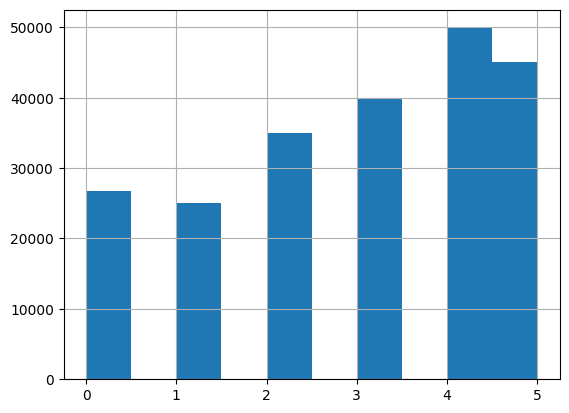

In [18]:
train["rating"].hist()

In [19]:
# shuffle the DataFrame rows
train = train.sample(frac = 1)
train.head()

,user_id,book_id,review_id,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments,rating
609458,3bdc763921371679843506792217a328,9791,6a734a157df0d7f0e160ac5ce87750bd,funny. i love bill bryson books,Fri Oct 10 16:54:31 -0700 2008,Fri Oct 10 16:54:31 -0700 2008,NaN,NaN,0,0,4
365183,31da2208f70f5208197facc12fc2b2de,16103765,3e1a09edc7b6be2b910d1178c848b35a,could not get past the first couple of chapter...,Sun Mar 02 10:06:11 -0800 2014,Sun Mar 02 10:06:38 -0800 2014,Thu Feb 20 00:00:00 -0800 2014,NaN,0,0,0
254208,e20b2a7d1007735150323b448871c93f,23734628,d4c016b2ee3d64c5eb4b9651455c2d67,i am giving up. it is been four months. it is ...,Thu May 28 23:31:17 -0700 2015,Sat Jul 15 19:53:06 -0700 2017,NaN,Sat Apr 15 00:00:00 -0700 2017,1,0,0
313345,c0e0fda388f87af0deffad748c9c8b67,9850284,5746accc3c2435b013e308696e58ea40,jack and tony are a fabulous couple and i like...,Sat Apr 14 10:33:04 -0700 2012,Sun Apr 15 13:02:56 -0700 2012,NaN,NaN,0,1,4
92867,ce51145d2632e96fd7cffabec8c6267b,18079542,17d7199538a72f1c9216a33998162f61,*************2/5************** ~~~~~~~~~~~me~...,Tue Dec 23 01:29:31 -0800 2014,Fri Dec 26 20:43:26 -0800 2014,Wed Dec 24 00:00:00 -0800 2014,Tue Dec 23 00:00:00 -0800 2014,1,0,2


In [20]:
def load_imdb_data(df):
    #df = pd.read_csv(data_file)
    texts = df['review_text'].tolist()
    labels = df['rating'].tolist()
    return texts, labels

In [21]:
texts, labels = load_imdb_data(train)

In [22]:
len(labels)

221795

In [23]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}

In [24]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        logits = self.fc(x)
        return logits

In [25]:
def train(model, data_loader, optimizer, scheduler, device):
    model.train()
    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

In [26]:
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions)

In [27]:
def predict_sentiment(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        return preds.item()

In [28]:
# Set up parameters
bert_model_name = 'bert-base-uncased'
num_classes = 6
max_length = 128
batch_size = 16
num_epochs = 4
learning_rate = 2e-5

In [29]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [30]:
print(len(train_texts))
print(len(train_labels))
print(len(val_texts))
print(len(val_labels))

177436
177436
44359
44359


In [31]:
train_texts[0]

'this sounds eerily like rat race meets the westing game and i think i am in love with it already.'

In [32]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

In [33]:
print(len(train_dataset))
print(len(val_dataset))
# print(val_texts.shape)
# print(val_labels.shape)

177436
44359


In [34]:
train_dataset[10]

{'input_ids': tensor([  101,  2761,  6866,  2012,  1024,  1045,  2514,  2428,  2919,  2138,
          1045,  2363,  2023,  2028,  1037,  2096,  2067,  1006,  2763,  1999,
          2254,  1007,  1010,  1998,  2001,  4011,  2000,  3319,  2009,  2005,
          1996,  9047,  3058,  2126,  2100,  2100,  2100,  2067,  1999,  2258,
          1012,  6854,  1010,  1045,  2196,  2288,  2105,  2000,  3752,  1998,
         15252,  2009,  1012,  1012,  1012,  2127,  2085,  1012,  2821, 10958,
         11607,  2232,  1012, 10958, 11607,  2232,  1010, 10958, 11607,  2232,
          1010, 10958, 11607,  2232,  1012, 13219,  1010,  5236, 10958, 11607,
          2232,   999,  1045,  2031,  2061,  2116, 23161,   999,  2425,  2033,
          2093,  2477,  2001,  6289,  1011,  5003,  6774,  1012,  2009,  2001,
          2066,  1037,  2402,  4639,  2544,  1997,  2017,  2031,  2288,  5653,
          1010,  3272,  2073,  1996,  4364,  4282,  2040,  2016,  2003,  2013,
          1996,  2707,  1012,  2293,  1

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(bert_model_name, num_classes).to(device)

In [36]:
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [37]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train(model, train_dataloader, optimizer, scheduler, device)
    accuracy, report = evaluate(model, val_dataloader, device)
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(report)

Epoch 1/4
Validation Accuracy: 0.5740
              precision    recall  f1-score   support

           0       0.74      0.55      0.63      5387
           1       0.62      0.59      0.60      4994
           2       0.52      0.59      0.55      6955
           3       0.54      0.48      0.51      7947
           4       0.49      0.63      0.55     10057
           5       0.70      0.59      0.64      9019

    accuracy                           0.57     44359
   macro avg       0.60      0.57      0.58     44359
weighted avg       0.59      0.57      0.58     44359

Epoch 2/4
Validation Accuracy: 0.5875
              precision    recall  f1-score   support

           0       0.74      0.59      0.66      5387
           1       0.62      0.67      0.64      4994
           2       0.56      0.51      0.53      6955
           3       0.55      0.49      0.52      7947
           4       0.53      0.52      0.52     10057
           5       0.61      0.76      0.67      9019

 

In [38]:
torch.save(model.state_dict(), "bert_classifier.pth")

In [39]:
from sklearn.metrics import confusion_matrix

def confusion_matrix_compute(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    return confusion_matrix(actual_labels, predictions)

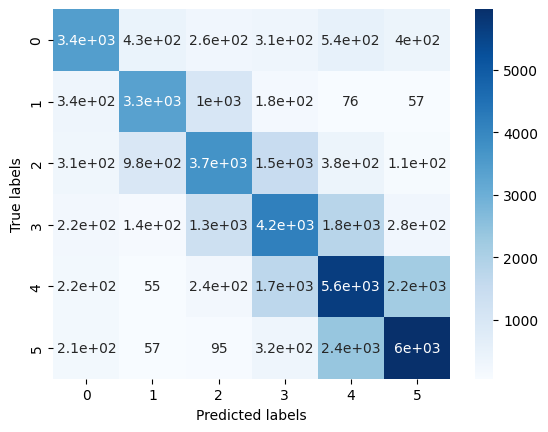

In [40]:
cm = confusion_matrix_compute(model, val_dataloader, device)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [41]:
test = pd.read_csv('/kaggle/input/ratemeter/test.csv')
test_original = test
test.head()

,user_id,book_id,review_id,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,de3a6a28c83cda006b415d45d64674c9,1618,d76ce5becf493e5c653610edb806ffc4,"I'm going to keep this review short, because I...",Tue Jun 09 10:37:48 -0700 2015,Wed Jun 10 13:43:38 -0700 2015,Wed Jun 10 14:08:39 -0700 2015,Tue Jun 09 00:00:00 -0700 2015,8,0
1,d9cfab35a87e32084b1817dfb0e98748,15776309,9c5c9aed79255a1a610dfc153ee90ad6,"You know, I was really stoked to see this come...",Mon Apr 22 09:19:40 -0700 2013,Wed Jul 10 14:34:27 -0700 2013,Wed Jul 10 14:34:27 -0700 2013,Tue Jul 09 00:00:00 -0700 2013,0,0
2,24935a870a46525a37be92775ab18f76,478927,ad26332459cda8f40581fef7a29b800c,This is one of those books where you know you ...,Sat Mar 14 12:16:55 -0700 2015,Sun Apr 05 11:25:00 -0700 2015,Wed Mar 18 00:00:00 -0700 2015,Sat Mar 14 00:00:00 -0700 2015,14,0
3,6ccb40eabdd0db7895aac00963256469,22628,5bb75768be7f2ddcd632336778b67f5a,The perks of being a wallflower \n What does a...,Sat Sep 12 08:43:30 -0700 2015,Sat Sep 12 09:19:29 -0700 2015,NaN,NaN,0,0
4,9f9d0f6e9a6a5797a252ef81abc9421c,13596809,3d7f76ea566b9ce0700772236094d936,"So, I wrote a review for this when I read it b...",Sun Jul 14 19:36:13 -0700 2013,Thu Jun 02 16:45:45 -0700 2016,Sat Mar 23 00:00:00 -0700 2013,NaN,0,0


In [42]:
# test_original = test_original.iloc[:500]
# test = test.iloc[:500]
test.shape

(270000, 10)

In [43]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270000 entries, 0 to 269999
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       270000 non-null  object
 1   book_id       270000 non-null  int64 
 2   review_id     270000 non-null  object
 3   review_text   270000 non-null  object
 4   date_added    270000 non-null  object
 5   date_updated  270000 non-null  object
 6   read_at       242459 non-null  object
 7   started_at    187740 non-null  object
 8   n_votes       270000 non-null  int64 
 9   n_comments    270000 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 20.6+ MB


In [44]:
# Text Lowercasing
test['review_text'] = test['review_text'].str.lower()

In [45]:
# Decontracting , removing html tags ang removing links
test['review_text'] = test['review_text'].apply(text_processing)

In [46]:
# Expand shortcuts
test['review_text'] = test['review_text'].apply(lambda x: expand(x))

In [47]:
def load_imdb_test_data(df):
    texts = df['review_text'].tolist()
    return texts

In [48]:
test_texts = load_imdb_test_data(test)

In [49]:
class TextClassificationTestDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten()}

In [50]:
test_dataset = TextClassificationTestDataset(test_texts, tokenizer, max_length)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [51]:
len(test_dataset)

270000

In [52]:
def predict_output(model, data_loader, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
    return predictions

In [53]:
y_pred_bert = predict_output(model, test_dataloader, device)

In [54]:
len(y_pred_bert)

270000

In [55]:
review_id_list = test_original['review_id'].to_numpy()
print(review_id_list[:10])
print(type(review_id_list))
print(review_id_list.shape)

['d76ce5becf493e5c653610edb806ffc4' '9c5c9aed79255a1a610dfc153ee90ad6'
 'ad26332459cda8f40581fef7a29b800c' '5bb75768be7f2ddcd632336778b67f5a'
 '3d7f76ea566b9ce0700772236094d936' 'ce5c9f3f6c9dbb7e1a141265d773e842'
 'fb280e8ecb1a6edf3fa511ba7a304dd6' '1ac5f014d18943fb5142d6f65bda688b'
 '9a959c707757a216447029b51ebb84d2' '43c72b5942588a51ec18600b36d064de']
<class 'numpy.ndarray'>
(270000,)


In [56]:
data_bert = {'review_id': review_id_list,
        'rating': y_pred_bert}


output_df_bert = pd.DataFrame(data_bert)
print(output_df_bert.shape)
output_df_bert.head()

(270000, 2)


,review_id,rating
0,d76ce5becf493e5c653610edb806ffc4,3
1,9c5c9aed79255a1a610dfc153ee90ad6,1
2,ad26332459cda8f40581fef7a29b800c,4
3,5bb75768be7f2ddcd632336778b67f5a,4
4,3d7f76ea566b9ce0700772236094d936,2


In [57]:
# saving the dataframe
output_df_bert.to_csv('output_bert.csv',header=True,index=False)